# Lecture #7: Latent Variable Models and MLE
## AM 207: Advanced Scientific Computing
### Stochastic Methods for Data Analysis, Inference and Optimization
### Fall, 2019

<img src="fig/logos.jpg" style="height:150px;">

In [2]:
### Import basic libraries
import numpy as np
import scipy as sp
import pandas as pd
import sklearn as sk
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
%matplotlib inline

## Administrative Matters

1. **Attendance Quiz:** <br><br>

## Outline
0. Review of Statistical Modeling
1. Motivation for Latent Variable Models
2. Common Latent Variable Models
3. Maximum Likelihood Estimation for Latent Variable Models: Expectation Maximization
4. Mixture of Gaussians

# Review of Statistical Modeling

## What We Can Do So Far
1. **(Models)** When we have observed data $Y_{\text{Obs}}$, we can model $Y_{\text{Obs}}$ as a random variable $Y_{\text{Obs}} \sim p(Y |\theta)$ with a known distribution $p$.
  - if $Y_{\text{Obs}}$ is a label, we can model it as a *Categorical* or *Bernoulli* variable
  - if $Y_{\text{Obs}}$ is a count, we can model it as a *Binomial*, *Multinomial* or *Poisson*
  - if $Y_{\text{Obs}}$ is continuous, we can model it as a *Gaussian*, *Exponential*, *Dirichlet* etc
 
2. **(Inference)** We can make statements about $\theta$ by performing:
   - ***Maximum Likelihood Estimation:*** compute a fixed value $\theta_{\text{MLE}}$ that maximizes the likelihood of the observed data $Y$.
   - ***Bayesian Inference:*** *assume* a prior for $\theta$, encoding our knowledge and uncertainty about $\theta$, then compute the posterior $p(\theta| Y)$ distribution. 
   
3. **(Inference Algorithm)** We choose an algorithm to perform inference:

  - ***Maximum Likelihood Estimation:*** *analytically* solve an unconstrained or contrained optimization problem to obtain $\theta_{\text{MLE}}$.
  - ***Bayesian Inference:*** 
    - if the prior and likelihood are ***conjugate***, then *analytically* derive the posterior distribution
    - if the posterior distribution does not have a known (to you) form, sample from it using a ***sampler***.
    

## What Happens After Inference?

1. **(Predictive Evaluation)** In practice, we do not know the true model $\theta_{\text{True}}$! Thus, $\theta_{\text{MLE}}$ and $p(\theta|Y)$ cannot be evaluated by comparison to $\theta_{\text{True}}$.
  - ***Maximimum Likelihood Estimation:*** we sample multiple $Y \sim p(Y| \theta_{\text{MLE}})$ and compare with observed data $Y_{\text{Obs}}$.
  - ***Bayesian Inference:*** we sample multiple $Y$ from the ***posterior predictive*** and compare with observed data $Y_{\text{Obs}}$.<br><br>

2. **(Uncertainty Evaluation)** Before making decisions with real-life consequence based on your model, you should check the precision of your estimate or uncertainty of you model.
  - ***Maximimum Likelihood Estimation:*** repeat the MLE computation on many bootstrap samples of $Y_{\text{Obs}}$. Compute the confidence interval of $\theta$ and the predictive interval for $Y$. These intervals indicate *precision*.
  - ***Bayesian Inference:*** Compute credible intervals for the posterior $p(\theta|Y)$ and the predictive intervals of the posterior predictive. These intervals indicate *model uncertainty*.

## The Modeling Process

<img src="fig/modeling.jpg" style="height:250px;">

# Motivation for Latent Variable Models

## A Model for Birth Weights
Recall our model for birth weigths, $Y_1,\ldots, Y_N$. We *posited* that the birth weights are iid normally distributed with known $\sigma^2$, $Y_n \sim \mathcal{N}(\mu, 1)$.

Compare the maximum likelihood model and the Bayesian model for bith weight. Which model would you use to make clinical decisions? What's hard about this comparison?

<img src="fig/compare.jpg" style="height:300px;">

## A Similarity Measure for Distributions: Kullback–Leibler Divergence

Visually comparing models to the ***empirical distribution*** of the data is impractical. Fortunately, there are a large number of quantitative measures for comparing two distributions, these are called ***divergence measures***. For example, the ***Kullback–Leibler (KL) Divergence*** is defined for two distributions $p(\theta)$ and $q(\theta)$ supported on $\Theta$ as:

$$
D_{\text{KL}}[q \,\|\, p] = \int_{\Theta} \log\left[\frac{q(\theta)}{p(\theta)} \right] q(\theta)d\theta
$$

The KL-divergence $D_{\text{KL}}[q \,\|\, p]$ is bounded below by 0, which happens if and only if $q=p$.
The KL-divergence has information theoretic interpretations that we will explore later in the course.

**Note:** The KL-divergence is defined in terms of the pdf's of $p$ and $q$. If $p$ is a distribution from which we only have samples and not the pdf (like the empirical distribution), we can nontheless estimate $D_{\text{KL}}[q \,\|\, p]$. Techniques that estimate the KL-divergence from samples are called ***non-parametric***. We will use them later in the course.

## Class Membership as a Latent Variable

We observe that there are three ***clusters*** in the data. We posit that there are three ***classes*** of infants in the study: infants with low birth weights, infants with normal birth weights and those with high birth weights. The numbers of infants in the classes are not equal.

For each observation $Y_n$, we model its class membership $Z_n$ as a categorical variable, 

$$Z_n\sim Cat(\pi),$$

where $\pi_i$ in $\pi = [\pi_1, \pi_2, \pi_3]$ is the class proportion. Note that we don't have the class membership $Z_n$ in the data! So $Z_n$ is called a ***latent variable***.

Depending on the class, the $n$-th birth weight $Y_n$ will have a different normal distribution,

$$
Y_n | Z_n \sim \mathcal{N}\left(\mu_{Z_n}, \sigma^2_{Z_n}\right)
$$

where $\mu_{Z_n}$ is one of the three class means $[\mu_1, \mu_2, \mu_3]$ and $\sigma^2_{Z_n}$ is one of the three class variances $[\sigma^2_1, \sigma^2_2, \sigma^2_3]$.

# Common Latent Variable Models

## Latent Variable Models

Models that include an observed variable $Y$ and at least one unobserved variable $Z$ are called ***latent variable models***. In general, our model can allow $Y$ and $Z$ to interact in many different ways. Today, we will study models with one type of interaction:

<img src="fig/graphical_model.jpg" style="height:300px;">

## Gaussian Mixture Models (GMMs)

In a ***Gaussian Mixture Model (GMM)***, we posit that the observed data $Y$ is generated by a mixture, $\pi=[\pi_1, \ldots, \pi_K]$, of $K$ number of Gaussians with means $\mu = [\mu_1, \ldots, \mu_K]$ and covariances $\Sigma = [\Sigma_1, \ldots, \Sigma_K]$. For each observation $Y_n$ the class of the observation $Z_n$ is a latent variable that indicates which of the $K$ Gaussian is responsible for generating $Y_n$:

\begin{aligned}
Z_n &\sim Cat(\pi),\\
Y_n | Z_n&\sim \mathcal{N}(\mu_{Z_n}, \Sigma_{Z_n}),
\end{aligned}
where $n=1, \ldots, N$ and $\sum_{k=1}^K \pi_k = 1$. 

GMMs are examples of ***model based clustering*** - breaking up a data set into natural clusters based on a statistical model fitted to the data.

## Item-Response Models

In ***item-response models***, we measure an real-valued unobserved trait $Z$ of a subject by performing a series of experiments with binary observable outcomes, $Y$:

\begin{aligned}
Z_n &\sim \mathcal{N}(\mu, \sigma^2),\\
\theta_n &= g(Z_n)\\
Y_n|Z_n &\sim Ber(\theta_n),
\end{aligned}

where $n=1, \ldots, N$ and $g$ is some fixed function of $Z_n$.

#### Applications
Item response models are used to model the way "underlying intelligence" $Z$ relates to scores $Y$ on IQ tests. 

Item response models can also be used to model the way "suicidality" $Z$ relates to answers on mental health surveys. Building a good model may help to infer when a patient is at psychiatric risk based on in-take surveys at points of care through out the health-care system.

## Factor Analysis Models

In ***factor analysis models***, we posit that the observed data $Y$ with many measurements is generated by a small set of unobserved factors $Z$:

\begin{aligned}
Z_n &\sim \mathcal{N}(0, I),\\
Y_n|Z_n &\sim \mathcal{N}(\mu + \Lambda Z_n, \Phi),
\end{aligned}

where $n=1, \ldots, N$, $Z_n\in \mathbb{R}^{D'}$ and $Y_n\in \mathbb{R}^{D}$. We typically assume that $D'$ is much smaller than $D$.

#### Applications
Factor analysis models are useful for biomedical data, where we typically measure a large number of characteristics of a patient (e.g. blood pressure, heart rate, etc), but these characteristics are all generated by a small list of health factors (e.g. diabetes, cancer, hypertension etc). Building a good model means we may be able to infer the list of health factors of a patient from their observed measurements.

# Maximum Likelihood Estimation for Latent Variable Models: Expectation Maximization

## Expectation Maximization: Estimating the MLE for Latent Variable Models

Given a latent variable model $p(Y, Z| \phi, \theta) = p(Y | Z, \phi) p(Z|\theta)$, we are interested computing the MLE of parameters $\phi$ and $\theta$:

\begin{aligned}
\theta_{\text{MLE}}, \phi_{\text{MLE}} &= \underset{\theta, \phi}{\mathrm{argmax}}\; \ell(\theta, \phi)\\
&= \underset{\theta, \phi}{\mathrm{argmax}}\; \log \prod_{n=1}^N \int_{\Omega_Z}  p(y_n, z_n | \theta, \phi) dz\\
&= \underset{\theta, \phi}{\mathrm{argmax}}\; \log \prod_{n=1}^N \int_{\Omega_Z}  p(y_n| z_n, \phi)p(z_n| \theta) dz
\end{aligned}
where $\Omega_Z$ is the domain of $Z$.
Why is this an hard optimization problem?

There are two major problems: 
1. the product in the integrand
2. gradients cannot be past the integral (i.e. we cannot easily compute the gradient to solve the optimization problem). 

We solve these two problems by: 
1. pushing the log past the integral so that it can be applied to the integrand (Jensen's Inequality)
2. introducing an auxiliary variables $q(Z_n)$ to allow the gradient to be pushed past the integral.

\begin{aligned}
\underset{\theta, \phi}{\mathrm{max}}\; \ell(\theta, \phi) &= \underset{\theta, \phi, q}{\mathrm{max}}\; \log \prod_{n=1}^N\int_{\Omega_Z} \left(\frac{p(y_n, z_n|\theta, \phi)}{q(z_n)}q(z_n)\right) dz\\
&= \underset{\theta, \phi, q}{\mathrm{max}}\; \log\,\prod_{n=1}^N\mathbb{E}_{Z\sim q(Z)} \left[  \frac{p(y_n, Z|\theta, \phi)}{q(Z)}\right]\\
&= \underset{\theta, \phi, q}{\mathrm{max}}\; \sum_{n=1}^N \log \mathbb{E}_{Z\sim q(Z)} \left[\,\left( \frac{p(y_n, Z|\theta, \phi)}{q(Z)}\right)\right]\\
&\geq \underset{\theta, \phi, q}{\mathrm{max}}\; \underbrace{\sum_{n=1}^N\mathbb{E}_{Z_n\sim q(Z)} \left[  \log\,\left(\frac{p(y_n, Z_n|\theta, \phi)}{q(Z_n)}\right)\right]}_{ELBO(\theta, \phi)}, \quad (\text{Jensen's Inequality})\\
\end{aligned}

We call $\sum_{n=1}^N\mathbb{E}_{Z_n\sim q(Z)} \left[ \log\,\left(\frac{p(y_n, Z_n|\theta, \phi)}{q(Z)}\right)\right]$ the Evidence Lower Bound (ELBO). Note that maximizing the ELBO will yield a lower bound of the maximum value of the log likelihood. Although **the optimal point of the ELBO may not be the optimal point of the log likelihood**, we nontheless prefer to optimize the ELBO because the gradients, with respect to $\theta, \phi$, of the ELBO are easier to compute:

$$
\nabla_{\theta, \phi} ELBO(\theta, \phi) = \nabla_{\theta, \phi}\left[ \sum_{n=1}^N\mathbb{E}_{Z_n\sim q(Z)} \left[  \log\,\left(\frac{p(y_n, Z_n|\theta, \phi)}{q(Z_n)}\right)\right]\right] =  \sum_{n=1}^N\mathbb{E}_{Z_n\sim q(Z)} \left[  \nabla_{\theta, \phi} \left( \log\,\left(\frac{p(y_n, Z_n|\theta, \phi)}{q(Z_n)}\right)\right)\right]
$$

Note that we can push the gradient $\nabla_{\theta, \phi}$ past the expectation $\mathbb{E}_{Z_n\sim q(Z)}$ since the expectation is not computed with respect to our optimization variables!

Rather than optimizing the ELBO over all variables $\theta, \phi, q$ (this would be hard), we optimize one set of variables at a time:

#### Step I: the M-step
Optimize the ELBO with respect to $\theta, \phi$:

\begin{aligned}
\theta^*, \phi^* = \underset{\theta, \phi}{\mathrm{max}}\; ELBO(\theta, \phi, q) &= \underset{\theta, \phi}{\mathrm{max}}\; \sum_{n=1}^N\mathbb{E}_{Z_n\sim q(Z)} \left[  \log\,\left(\frac{p(y_n, Z_n|\theta, \phi)}{q(Z_n)}\right)\right]\\
&= \underset{\theta, \phi}{\mathrm{max}}\;  \sum_{n=1}^N \int_{\Omega_Z} \log\,\left(\frac{p(y_n, z_n|\theta, \phi)}{q(z_n)}\right)q(z_n) dz_n\\
&= \underset{\theta, \phi}{\mathrm{max}}\; \sum_{n=1}^N \int_{\Omega_Z} \log\,\left(p(y_n, z_n|\theta, \phi)\right) q(z_n)dz_n - \underbrace{\int_{\Omega_Z} \log \left(q(z_n)\right)q(z_n) dz_n}_{\text{constant with respect to }\theta, \phi}\\
&\equiv \underset{\theta, \phi}{\mathrm{max}}\;\sum_{n=1}^N \int_{\Omega_Z} \log\,\left(p(y_n, z_n|\theta, \phi)\right) q(z_n)dz_n\\
&= \underset{\theta, \phi}{\mathrm{max}}\;\sum_{n=1}^N \mathbb{E}_{Z_n\sim q(Z)} \left[ \log\left(p(y_n, z_n|\theta, \phi)\right)\right]
\end{aligned}

#### Step II: the E-step
Optimize the ELBO with respect to $q$:

\begin{aligned}
q^*(Z_n) = \underset{q}{\mathrm{argmax}}\;\left(\underset{\theta, \phi}{\mathrm{argmax}}\; ELBO(\theta, \phi, q) \right) = \underset{q}{\mathrm{argmax}}\; ELBO(\theta^*, \phi^*, q)
\end{aligned}

Rather than optimizing the ELBO with respect to $q$, which seems hard, we will argue that optimizing the ELBO is equivalent to optimizing another function of $q$, one whose optimum is easy for us to compute.

**Note:** We can recognize the difference between the log likelihood and the ELBO as a function we've seen:

\begin{aligned}
\ell(\theta, \phi) - ELBO(\theta, \phi, q) &= \sum_{n=1}^N \log p(y_n| \theta, \phi) - \sum_{n=1}^N \int_{\Omega_Z} \log\left(\frac{p(y_n, z_n|\theta, \phi)}{q(z_n)}\right)q(z_n) dz_n\\
&=  \sum_{n=1}^N \int_{\Omega_Z} \log\left(p(y_n| \theta, \phi)\right) q(z_n) dz_n - \sum_{n=1}^N \int_{\Omega_Z} \log\left(\frac{p(y_n, z_n|\theta, \phi)}{q(z_n)}\right)q(z_n) dz_n\\
&=  \sum_{n=1}^N \int_{\Omega_Z}  \left(\log\left(p(y_n| \theta, \phi)\right) - \log\left(\frac{p(y_n, z_n|\theta, \phi)}{q(z_n)}\right) \right)q(z_n) dz_n\\
&= \sum_{n=1}^N \int_{\Omega_Z}  \log\left(\frac{p(y_n| \theta, \phi)q(z_n)}{p(y_n, z_n|\theta, \phi)} \right)q(z_n) dz_n\\
&= \sum_{n=1}^N \int_{\Omega_Z}  \log\left(\frac{q(z_n)}{p(z_n| y_n, \theta, \phi)} \right)q(z_n) dz_n, \quad\left(\text{Baye's Rule: } \frac{p(y_n, z_n|\theta, \phi)}{p(y_n| \theta, \phi)} = p(z_n| y_n, \theta, \phi)\right)\\
&= \sum_{n=1}^N D_{\text{KL}} \left[ q(Z_n) \| p(Z_n| Y_n, \theta, \phi)\right].
\end{aligned}

Since $\ell(\theta, \phi)$ is a constant, the difference $\sum_{n=1}^N D_{\text{KL}} \left[ q(Z_n) \| p(Z_n| Y_n, \theta, \phi)\right] = \ell(\theta, \phi) - ELBO(\theta, \phi, q)$ descreases when $ELBO(\theta, \phi, q)$ increases (and vice versa). Thus, maximizing the ELBO is equivalent to minimizing $D_{\text{KL}} \left[ q(Z_n) \| p(Y_n| Z_n, \theta, \phi)\right]$:

$$
\underset{q}{\mathrm{argmax}}\, ELBO(\theta, \phi, q) = \underset{q}{\mathrm{argmin}}\sum_{n=1}^N D_{\text{KL}} \left[ q(Z_n) \| p(Z_n| Y_n, \theta, \phi)\right].
$$

Thus, we see that 
\begin{aligned}
q^*(Z_n) = \underset{q}{\mathrm{argmax}}\; ELBO(\theta^*, \phi^*, q) = \underset{q}{\mathrm{argmin}}\sum_{n=1}^N D_{\text{KL}} \left[ q(Z_n) \| p(Z_n| Y_n, \theta, \phi)\right] = p(Z_n| Y_n, \theta, \phi)
\end{aligned}

That is, we should set the optimal distribution $q$ to be the posterior $p(Z_n| Y_n, \theta, \phi)$.

#### Iteration
Of course, we know that optimizing a function with respect to each variable is not sufficient for finding the global optimum over all the variables, considered together! Thus, performing one E-step and one M-step is not enough to maximize the ELBO. We need to repeat the two steps over and over.

## The Expectation Maximization Algorithm

The ***exepectation maximization (EM) algorithm*** maximize the ELBO of the model,
<img src="fig/graphical_model.jpg" style="height:150px;">
0. **Initialization:** Pick $\theta_0$, $\phi_0$.
1. Repeat $i=1, \ldots, I$ times:

  **E-Step:** 
$$q_{\text{new}}(Z_n) = \underset{q}{\mathrm{argmax}}\; ELBO(\theta_{\text{old}}, \phi_{\text{old}}, q) = p(Z_n|Y_n, \theta_{\text{old}}, \phi_{\text{old}})$$

  **M-Step:** 
  \begin{aligned}
  \theta_{\text{new}}, \phi_{\text{new}} &= \underset{\theta, \phi}{\mathrm{argmax}}\; ELBO(\theta, \phi, q_{\text{new}})\\
  &= \underset{\theta, \phi}{\mathrm{argmax}}\; \sum_{n=1}^N\mathbb{E}_{Z_n\sim p(Z_n|Y_n, \theta_{\text{old}}, \phi_{\text{old}})}\left[\log \left( p(y_n, Z_n | \phi, \theta\right) \right].
\end{aligned}

## The Auxiliary Function

We often denote the expectation in the M-step by $Q\left(\theta, \phi| \theta^{\text{old}}, \phi^{\text{old}}\right)$
$$
Q\left(\theta, \phi| \theta^{\text{old}}, \phi^{\text{old}}\right) = \sum_{n=1}^N\mathbb{E}_{Z_n\sim p(Z_n|Y_n, \theta_{\text{old}}, \phi_{\text{old}})}\left[\log \left( p(y_n, Z_n | \phi, \theta\right) \right]
$$
and call $Q$ the auxiliary function. 

Frequently, the EM algorithm is equivalently presented as
- E-step: compute the auxiliary function: $Q\left(\theta, \phi| \theta^{\text{old}}, \phi^{\text{old}}\right)$
- M-step: maximize the auxiliary function: $\theta^{\text{new}}, \phi^{\text{new}} = \underset{\theta, \phi}{\mathrm{argmax}}\,Q\left(\theta, \phi| \theta^{\text{old}}, \phi^{\text{old}}\right)$.

The log of the joint distribution $\prod_{n=1}^N p(Z_n, Y_n, \theta, \phi)$ is called the ***complete data log-likelihood*** (since it is the likelihood of both observed and latent variables), whereas $\log \prod_{n=1}^N p(Y_n| \theta, \phi)$ is called the ***observed data log-likelihood*** (since it is the likelihood of only the observed variable).

The auxiliary function presentation of EM is easy to interpret:
- In the E-step, you fill in the latent variables in the complete data log-likelihood using "average" values, this leaves just an estimate of the observed log-likelihood.
- In the M-step, you find parameters $\phi$ and $\theta$ that maximizes your estimate of the observed log-likelihood.

We chose to derive EM via the ELBO in this lecture because it makes an explicit connection between the EM algorithm for estimating MLE and variational inference method for approximating the posterior of Bayesian models. It is, however, worthwhile to derive EM using the auxiliary function $Q$, as $Q$ makes it convient for us to prove properties of the EM algorithm.

## Monotonicity and Convergence of EM

Before we run off estimating MLE parameters of latent variable models with EM, we need to sanity check two points:

1. **(Monotonicity)** we need to know that repeating the E, M-steps will never decrease the ELBO!
2. **(Convergence)** we need to know that at some point the EM algorithm will naturally terminate (the algorithm will cease to update the parameters).

We first prove the monotonicity of EM. Consider the difference between $\ell(\theta, \phi) - \ell(\theta^{\text{old}}, \phi^{\text{old}})$, i.e. the amount by which the log-likelihood can increase or decrease by going from $\theta^{\text{old}}, \phi^{\text{old}}$ to $\theta, \phi$:

\begin{aligned}
\ell(\theta, \phi) - \ell(\theta^{\text{old}}, \phi^{\text{old}}) &= \sum_{n=1}^N\log \left[ \frac{p(y_n|\theta, \phi)}{p(y_n| \theta^{\text{old}}, \phi^{\text{old}})}\right]\\
&= \sum_{n=1}^N \log\int \frac{p(y_n, z_n|\theta, \phi)}{p(y_n| \theta^{\text{old}}, \phi^{\text{old}})} dz_n\\
&= \sum_{n=1}^N \log\int \frac{p(y_n, z_n|\theta, \phi)}{p(y_n| \theta^{\text{old}}, \phi^{\text{old}}) p(z_n|y_n, \theta^{\text{old}}, \phi^{\text{old}})}p(z_n|y_n, \theta^{\text{old}}, \phi^{\text{old}}) dz_n\\
&= \sum_{n=1}^N \log\int \frac{p(y_n, z_n|\theta, \phi)}{p(y_n, z_n| \theta^{\text{old}}, \phi^{\text{old}})}p(z_n|y_n, \theta^{\text{old}}, \phi^{\text{old}}) dz_n\\
&= \sum_{n=1}^N \log \mathbb{E}_{p(z_n|y_n, \theta^{\text{old}}, \phi^{\text{old}})} \left[\frac{p(y_n, z_n|\theta, \phi)}{p(y_n, z_n| \theta^{\text{old}}, \phi^{\text{old}})}\right]\\
&\geq \sum_{n=1}^N  \mathbb{E}_{p(z_n|y_n, \theta^{\text{old}}, \phi^{\text{old}})} \log\left[\frac{p(y_n, z_n|\theta, \phi)}{p(y_n, z_n| \theta^{\text{old}}, \phi^{\text{old}})}\right]\\
&= \sum_{n=1}^N  \mathbb{E}_{p(z_n|y_n, \theta^{\text{old}}, \phi^{\text{old}})} \left[\log  p(y_n, z_n|\theta, \phi) - \log p(y_n, z_n| \theta^{\text{old}}, \phi^{\text{old}})\right]\\
&= \sum_{n=1}^N  \mathbb{E}_{p(z_n|y_n, \theta^{\text{old}}, \phi^{\text{old}})} \left[\log  p(y_n, z_n|\theta, \phi)\right] - \sum_{n=1}^N  \mathbb{E}_{p(z_n|y_n, \theta^{\text{old}}, \phi^{\text{old}})}\left[ \log  p(y_n, z_n| \theta^{\text{old}}, \phi^{\text{old}})\right]\\
&= Q\left(\theta, \phi| \theta^{\text{old}}, \phi^{\text{old}}\right) - Q\left(\theta^{\text{old}}, \phi^{\text{old}}| \theta^{\text{old}}, \phi^{\text{old}}\right)
\end{aligned}

Thus, when we maximize the gain in log-likelihood going from $\theta^{\text{old}}, \phi^{\text{old}}$ to $\theta, \phi$, we get:

\begin{aligned}
\underset{\theta, \phi}{\max} \left[\ell(\theta, \phi) - \ell(\theta^{\text{old}}, \phi^{\text{old}})\right] \geq \underset{\theta, \phi}{\max} \left[Q\left(\theta, \phi| \theta^{\text{old}}, \phi^{\text{old}}\right) - Q\left(\theta^{\text{old}}, \phi^{\text{old}}| \theta^{\text{old}}, \phi^{\text{old}}\right)\right]
\end{aligned}

or equivalently,

\begin{aligned}
\underset{\theta, \phi}{\max} \left[\ell(\theta, \phi)\right] - \ell(\theta^{\text{old}}, \phi^{\text{old}}) \geq \underset{\theta, \phi}{\max} \left[Q\left(\theta, \phi| \theta^{\text{old}}, \phi^{\text{old}}\right)\right] - Q\left(\theta^{\text{old}}, \phi^{\text{old}}| \theta^{\text{old}}, \phi^{\text{old}}\right).
\end{aligned}

Note that the above max is always greater than or equal to zero: 

$$\underset{\theta, \phi}{\max} \left[Q\left(\theta, \phi| \theta^{\text{old}}, \phi^{\text{old}}\right)\right] - Q\left(\theta^{\text{old}}, \phi^{\text{old}}| \theta^{\text{old}}, \phi^{\text{old}}\right) \geq 0$$ 

since we can always maintain the status quo by choosing $theta = \theta^{\text{old}}$ $\phi = \phi^{\text{old}}$:

$$ Q\left(\theta^{\text{old}}, \phi^{\text{old}}| \theta^{\text{old}}, \phi^{\text{old}}\right) - Q\left(\theta^{\text{old}}, \phi^{\text{old}}| \theta^{\text{old}}, \phi^{\text{old}}\right) = 0.$$

Thus, we have that by maximizing $Q\left(\theta, \phi| \theta^{\text{old}}, \phi^{\text{old}}\right)$, we ensure that $\ell(\theta, \phi) - \ell(\theta^{\text{old}}, \phi^{\text{old}})\geq 0$ in each iteration of EM.


If the likelihood of the model is bounded above (i.e. $\ell(\theta, \phi) \leq M$ for some constant $M$), then EM is guaranteed to convergence. This is because we've proved that EM increases (or maintains) log-likelihood in each iteration, therefore, if $\ell(\theta, \phi)$ is bounded, the process must converge. 


#### Disclaimer:
Although EM converges for bounded likelihoods, it is not guaranteed to converge to the global max of the log-likelihood! Maximizing a lower bound of a function does not necessarily maximize the function itself! Often time, EM converges to local optima of the likelihood function and the point to which it converges may be very sensitive to initialization. We will study this kind of behaviour in more detail when we cover non-convex optimization later in the course.

<img src="fig/EM.jpg" style="height:350px;">

## Example: EM for the Gaussian Mixture Model of Birth Weight
The Gaussian mixture model for the birth weight data has 3 Gaussians with meand $\mu = [\mu_1, \mu_2, \mu_3]$ and variances $\sigma^2 = [\sigma_1^2, \sigma_2^2, \sigma_3^2]$, and the model is defined as:
\begin{aligned}
Z_n &\sim Cat(\pi),\\
Y_n &\sim \mathcal{N}(\mu_{Z_n}, \sigma^2_{Z_n}),
\end{aligned}
where $n=1, \ldots, N$ and $\sum_{k=1}^3 \pi_k = 1$. 

### The E-Step

The E-step in EM computes the distribution:
$$q_{\text{new}}(Z_n) = \underset{q}{\mathrm{argmax}}\; ELBO(\mu_{i-1}, \sigma^2_{i-1}, \pi_{i_1}, q) = p(Z_n|Y_n, \mu_{\text{old}}, \sigma^2_{\text{old}}, \pi_{\text{old}}).$$ 
Since $Z_n$ is a label, $p(Z_n|Y_n, \ldots)$ is a categorical distribution, with the probability of $Z_n=k$ given by:

$$
p(Z_n = k|Y_n, \mu_{\text{old}}, \sigma^2_{\text{old}}, \pi_{\text{old}}) = \frac{p(y_n|Z_n = k, \mu_{\text{old}}, \sigma^2_{\text{old}})p(Z_n=k | \pi_{\text{old}})}{\sum_{k=1}^K p(y|Z_n = k, \mu_{\text{old}}, \sigma^2_{\text{old}})p(Z_n=k | \pi_{\text{old}})} = \underbrace{\frac{\pi_{k, \text{old}}\,\mathcal{N}(y_n; \mu_{k, \text{old}}, \sigma^2_{k, \text{old}})}{\mathcal{Z}}}_{r_{n, k}},
$$
where $\mathcal{Z} = \sum_{k=1}^K \pi_{k, \text{old}}\,\mathcal{N}(y_n; \mu_{k, \text{old}}, \sigma^2_{k, \text{old}})$.

## Example: EM for the Gaussian Mixture Model of Birth Weight
### Setting Up the M-Step

The M-step in EM maximize the following: 
$$\underset{\mu, \sigma^2, \pi}{\mathrm{argmax}}\; ELBO(\mu, \sigma^2, \pi, q_{\text{new}}) = \underset{\mu, \sigma^2, \pi}{\mathrm{argmax}}\; \sum_{n=1}^N\mathbb{E}_{Z_n\sim p(Z_n|Y_n, \mu_{k, \text{old}}, \sigma^2_{k, \text{old}})}\left[\log \left( p(y_n, Z_n | \mu, \sigma^2, \pi\right) \right].$$

If we expand the expectation a little, we get:
\begin{aligned}
\sum_{n=1}^N\mathbb{E}_{Z_n\sim p(Z_n|Y_n, \mu_{\text{old}}, \sigma^2_{\text{old}}, \pi_{\text{old}})}\left[\log \left(p(y_n, Z_n | \mu, \sigma^2, \pi) \right) \right] &= \sum_{n=1}^N \underbrace{\sum_{n=1}^K \log \left(\underbrace{ p(y_n| Z_n=k, \mu, \sigma^2) p(Z_n=k| \pi)}_{\text{factoring the joint }p(y_n, Z_n| \ldots) } \right) p(Z_n=k|y_n, \theta_{\text{old}}, \phi_{\text{old}})}_{\text{expanding the expectation}}\\
&=\sum_{n=1}^N \sum_{k=1}^K \underbrace{r_{n, k}}_{p(Z_n=k|y_n, \theta_{\text{old}}, \phi_{\text{old}})} \left[\log \underbrace{\mathcal{N}(y_n; \mu_k, \sigma^2_k)}_{p(y_n| Z_n=k, \mu, \sigma^2)}  + \log \underbrace{\pi_k}_{p(Z_n=k| \pi)}\right]\\
&= \underbrace{\sum_{n=1}^N \sum_{k=1}^K r_{n, k} \log \mathcal{N}(y_n; \mu_k, \sigma^2_k)}_{\text{Term #1}} + \underbrace{\sum_{n=1}^N \sum_{k=1}^K r_{n, k}\pi_k}_{\text{Term #2}} 
\end{aligned}
We can maximize each Term #1 and Term #2 individually.

## Example: EM for the Gaussian Mixture Model of Birth Weight
### Solving the M-Step

We see that the optimization problem in the M-step: $\mu_{\text{new}}, \sigma^2_{\text{new}}, \pi_{\text{new}} = \underset{\mu, \sigma^2, \pi}{\mathrm{argmax}}\; ELBO(\mu, \sigma^2, \pi, q_{\text{new}})$ is equivalent to two problems
\begin{aligned}
&1.\quad \underset{\mu, \sigma^2}{\mathrm{argmax}}\; \sum_{n=1}^N \sum_{k=1}^K r_{n, k} \log \mathcal{N}(y_n; \mu_k, \sigma^2_k)\\
&2.\quad \underset{\pi}{\mathrm{argmax}}\; \sum_{n=1}^N \sum_{k=1}^K r_{n, k}\pi_k
\end{aligned}
We can solve each optimization problem analytically by finding stationary points of the gradient (or the Lagrangian):
- $\mu_{\text{new}} = \frac{1}{ \sum_{n=1}^N r_{n, k}} \sum_{n=1}^N r_{n, k} y_n$

- $\sigma^2_{\text{new}} = \frac{1}{ \sum_{n=1}^N r_{n, k}} \sum_{n=1}^N r_{n, k} (y_n - \mu_{\text{new}})^2$

- $\pi_{\text{new}} =  \frac{\sum_{n=1}^N r_{n, k}}{N}$

## Example: EM for the Gaussian Mixture Model of Birth Weight
### All Together

**Initialization:**
Pick any $\pi$, $\mu$, $\sigma^2$

**E-Step:**
Compute $r_{n, k} = \displaystyle\frac{\pi_{k, \text{old}}\,\mathcal{N}(y_n; \mu_{k, \text{old}}, \sigma^2_{k, \text{old}})}{\mathcal{Z}}$, where $\mathcal{Z} = \sum_{k=1}^K \pi_{k, \text{old}}\,\mathcal{N}(y_n; \mu_{k, \text{old}}, \sigma^2_{k, \text{old}})$.

**M-Step:**
Compute model parameters:
- $\mu_{\text{new}} = \frac{1}{ \sum_{n=1}^N r_{n, k}} \sum_{n=1}^N r_{n, k} y_n$

- $\sigma^2_{\text{new}} = \frac{1}{ \sum_{n=1}^N r_{n, k}} \sum_{n=1}^N r_{n, k} (y_n - \mu_{\text{new}})^2$

- $\pi_{\text{new}} =  \frac{\sum_{n=1}^N r_{n, k}}{N}$

## Implementing EM for the Gaussian Mixture Model of Birth Weight

In [160]:
#Generate data
N = 2000
pis = [0.2, 0.6, 0.2]
mus = [4.3, 6, 7.8]
sigmas = [0.5**2, 0.7**2, 0.5**2]
K = 3
zs = np.random.choice(np.arange(K), size=N, p=pis)
y = np.array([np.random.normal(mus[z], sigmas[z]**0.5, 1)[0] for z in zs])

#initialization
mu_init = [2, 4, 5]
sigma_init = [2., 2., 2.]
pi_init = [0.33, 0.33, 0.33]

#implement EM
mu_current = mu_init
sigma_current = sigma_init
pi_current = pi_init

total_iter = 1500

for i in range(total_iter):
    #E-step
    r_unnormalized = np.array([(pi_current[k] *  sp.stats.norm(mu_current[k], sigma_current[k]**0.5).pdf(y)) for k in range(K)]).T
    r = r_unnormalized / r_unnormalized.sum(axis=1).reshape((-1, 1))
    #M-step
    mu_next = np.array([1. / r[:, k].sum() * (r[:, k] * y).sum() for k in range(K)])
    sigma_next = np.array([1. / r[:, k].sum() * (r[:, k] * (y - mu_next[k])**2).sum() for k in range(K)])
    pi_next = r.sum(axis=0) / r.shape[0]
    
    #convergence check
    if i % 500 == 0:
        print(np.linalg.norm(mu_next - mu_current), np.linalg.norm(sigma_next - sigma_current), np.linalg.norm(pi_next - pi_current))
    
    mu_current = mu_next
    sigma_current = sigma_next
    pi_current = pi_next
    
x = np.linspace(y.min(), y.max(), 100)

3.2920267342544727 1.5260468747347409 0.4291651611436793
5.4199527046935135e-06 7.163537707115768e-06 3.7030642797622287e-06
4.847421726967444e-10 6.412799516536099e-10 3.313286159742346e-10


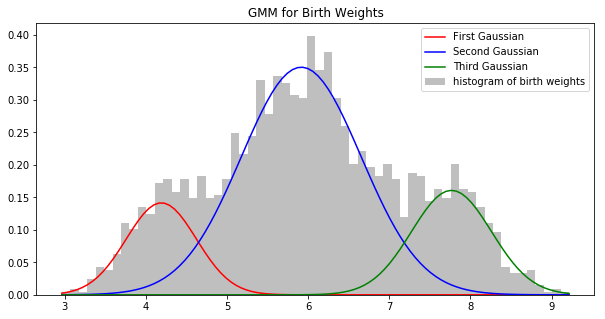

In [161]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.hist(y, bins=60, density=True, color='gray', alpha=0.5, label='histogram of birth weights')
ax.plot(x, pi_current[0] * sp.stats.norm(mu_current[0], sigma_current[0]**0.5).pdf(x), color='red', label='First Gaussian')
ax.plot(x, pi_current[1] * sp.stats.norm(mu_current[1], sigma_current[1]**0.5).pdf(x), color='blue', label='Second Gaussian')
ax.plot(x, pi_current[2] * sp.stats.norm(mu_current[2], sigma_current[2]**0.5).pdf(x), color='green', label='Third Gaussian')
ax.set_title('GMM for Birth Weights')
ax.legend(loc='best')
plt.show()

## Example: EM for Gaussian Mixture Models (Multivariate)

Recall that our Gaussian mixture model, of $K$ number of Gaussians with means $\mu = [\mu_1, \ldots, \mu_K]$ and covariances $\Sigma = [\Sigma_1, \ldots, \Sigma_K]$, is defined as:

\begin{aligned}
Z_n &\sim Cat(\pi),\\
Y_n &\sim \mathcal{N}(\mu_{Z_n}, \Sigma_{Z_n}),
\end{aligned}
where $n=1, \ldots, N$ and $\sum_{k=1}^K \pi_k = 1$. 

We derive the updates for $\pi$, $\mu$ and $\Sigma$ for the EM algorithm
#### E-step:
$$
q_{\text{new}} = p(Z_n|y_n, \pi_{\text{old}}, \mu_{\text{old}}, \Sigma_{\text{old}}) = \frac{p(y_n|Z_n, \mu_{\text{old}}, \Sigma_{\text{old}})p(Z_n|\pi_{\text{old}})}{\int p(y_n|z_n, \mu_{\text{old}}, \Sigma_{\text{old}})p(z_n|\pi_{\text{old}}) dz_n}
$$

Since $Z_n$ is a categorical variable, we compute the probability of $Z_n = k$ separately:

$$
p(Z_n = k|y_n, \pi_{\text{old}}, \mu_{\text{old}}, \Sigma_{\text{old}}) = \frac{p(y_n|Z_n = k, \mu_{\text{old}}, \Sigma_{\text{old}})p(Z_n=k | \pi_{\text{old}})}{\sum_{k=1}^K p(y|Z_n = k, \mu_{\text{old}}, \Sigma_{\text{old}})p(Z_n=k | \pi_{\text{old}})} = \underbrace{\frac{\pi_{k, \text{old}}\,\mathcal{N}(y_n; \mu_{k, \text{old}}, \Sigma_{k, \text{old}})}{\mathcal{Z}}}_{r_{n, k}}
$$

where $\mathcal{Z} = \sum_{k=1}^K \pi_{k, \text{old}}\,\mathcal{N}(y_n; \mu_{k, \text{old}}, \Sigma_{k, \text{old}})$.

Thus, $q_{\text{new}}(Z_n)$ is a categorical distribution $Cat([r_{n, 1}, \ldots, r_{n, K}])$.

#### M-Step:

\begin{aligned}
\mu_{\text{new}}, \Sigma_{\text{new}}, \pi_{\text{new}} &= \underset{\mu, \Sigma, \pi}{\mathrm{argmax}}\, \sum_{n=1}^N\mathbb{E}_{Z_n\sim p(Z_n|Y_n, \mu_{\text{old}}, \Sigma_{\text{old}}, \pi_{\text{old}})}\left[\log \left( p(y_n, Z_n | \mu, \sigma \right) \right]\\
&= \underset{\mu, \Sigma, \pi}{\mathrm{argmax}}\,\sum_{n=1}^N \sum_{k=1}^K r_{n, k} \left[\log p(y_n | Z_n=k, \mu, \Sigma)  + \log p(Z_n=k | \pi)\right]\\
&= \underset{\mu, \Sigma}{\mathrm{argmax}}\,\sum_{n=1}^N \sum_{k=1}^K r_{n, k} \log p(y_n | Z_n=k, \mu, \Sigma)  + \underset{\pi}{\mathrm{argmax}}\,\sum_{n=1}^N \sum_{k=1}^K r_{n, k} \log p(Z_n=k | \pi)\\
&=\underset{\mu, \Sigma}{\mathrm{argmax}}\,\sum_{n=1}^N \sum_{k=1}^K r_{n, k} \log \mathcal{N}(y_n; \mu_{k}, \Sigma_{k})  + \underset{\pi}{\mathrm{argmax}}\,\sum_{n=1}^N \sum_{k=1}^K r_{n, k} \log \pi_k
\end{aligned}
where $n=1, \ldots, N$ and $\sum_{k=1}^K \pi_k = 1$. 

We solve the two optimization problems separately. The optimization problem

$$
\underset{\pi}{\mathrm{argmax}}\,\sum_{n=1}^N \sum_{k=1}^K r_{n, k} \log \pi_k,\quad \sum_{k=1}^K \pi_k = 1
$$

can be solved using Lagrangian multipliers yielding the solution:

$$
\pi_{\text{new}, k} = \frac{\sum_{n=1}^N r_{n, k}}{N}
$$

The optimization problem 

$$
\underset{\mu, \Sigma}{\mathrm{argmax}}\,\sum_{n=1}^N \sum_{k=1}^K r_{n, k} \log \mathcal{N}(y_n; \mu_{k}, \Sigma_{k}) 
$$

can be solved by taking the gradient with respect to $\mu_k$, $\Sigma_k$ for each $k$ and computing the stationary points of the gradient (remember to check for the global concavity to ensure you've found a global max). Doing so gives us the optimal points

\begin{aligned}
\mu_{\text{new},k} &= \frac{1}{\sum_{n=1}^N r_{n, k}} \sum_{n=1}^N r_{n,k}y_n, &\quad (\text{weighted sample mean})\\
\Sigma_{\text{new},k} &= \frac{1}{\sum_{n=1}^N r_{n, k}}  \sum_{n=1}^N r_{n,k} (y_n - \mu_{\text{new},k})(y_n - \mu_{\text{new},k})^\top, &\quad (\text{weighted sample covariance})
\end{aligned}

**Exercise:** Verify that the updates for $\pi_{\text{new},k}, \mu_{\text{new},k}, \Sigma_{\text{new},k}$ maximizes $\mathbb{E}_{Z_n\sim p(Z_n|Y_n, \mu_{\text{old}}, \Sigma_{\text{old}}, \pi_{\text{old}})}\left[\log \left( p(y_n, Z_n | \mu, \sigma \right) \right]$.